# Measuring technological proximity in vector space 

Web Data Science - Project Submission

*Julian Dörr*

## Setup 

Let's load all required modules first.

In [5]:
import pandas as pd
import numpy as np
import pickle as pkl
from tqdm import tqdm
from pyprojroot import here
from collections import Counter
import spacy
import re
import config
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib
sns.set_theme(style="white")
#%matplotlib inline

Make tables in markdown cells left-aligned.

In [2]:
%%html
<style>
table {float:left}
</style>

## Project idea 

This project aims at **modeling semantic descriptions of** specific **technology** groups (e.g. carbon capture & storage technologies) **based on** expert labeled **patent texts**. The semantic technology descriptions shall then be used to **assess to what extent a firm has adopted to the underlying technology**. For this purpose, **company descriptions** as textual representation of a firm's business profile are used. Methods from the field **Natural Language Processing** (NLP) are used to turn both patent texts and company descriptions into numeric representations which allows to examine proximity between the two.

> <span style='background :lightgreen'> **Can we measure whether a company uses a specific technology based on textual information about the company (e.g. company descriptions, corporate websites)?** </span>



<center><img src="../04_Writing/01_Figures/fig_patent2tech2company.png" width="700"></center>

## Loading and preprocessing data 

First, we load the patent data.

In [6]:
df = pd.read_pickle(here(r'.\01_Data\01_Patents\epo2vvc_patents.pkl'))

In [4]:
# Propriatory data!
#df.head(3)

Since the patent data is propriatory, I am not allowed to share/show it publicly! Anyways, the following table shall give an idea how the data (`df`) is structured:

| ID  | CPC |                                                                                                                            ABSTRACT |
|:-----|:--------------------------|:---------------------------------------------------------------------------------------------------------------------------------------|
| 1   | [A, Y02C]                | Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam ... |
| 2   | [D, F, Y02A]             |         Sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Diam quis enim lobortis scelerisque ... |
| ... | ...                      |                                                                                                                                    ... |
| $P$   | [B]                      |              Nunc mi ipsum faucibus vitae. Diam quis enim lobortis scelerisque. Est placerat in egestas erat imperdiet sed euismod ... |

Think of the technology class (`CPC` in the table above) as an expert labeled assignment of the patent to a narrowly defined technology group.

In [4]:
len(df)

559419

Overall, the dataset comprises $P = 559,419$ distinct patents.

### Text preprocessing 

Next, we process the patent texts to make them suitable for downstream text modeling tasks. 

[**spaCy**](https://spacy.io/) is a free, open-source library for advanced Natural Language Processing (NLP) in Python. Offering trained pipelines spaCy is a useful module to conduct linguistic machine learning tasks such as tokenization, part-of-speech (POS) tagging and lemmatization under the hood. This requires loading a pre-trained and language-specific [model pipeline](https://spacy.io/models) in the first place. I choose `en_core_web_sm` for this purpose.

In [51]:
nlp = spacy.load("en_core_web_sm")

In order to make the pre-trained pipeline suitable for the task of preprocessing patent texts, I implement some adjustments to default components.

Default tokenizer seperates hyphen words in three tokens e.g.:
- photo-sensor -> ['photo', '-', 'sensor']
- aluminum-silicon -> ['aluminium', '-', 'silicon']

In the context of developing semantic spaces for different technologies this is undesirable as hyphen words possibly carry high value in terms of describing the underlying technology. Thus, the default tokenizer will be customized to convert hyphen words into a single token:
- photo-sensor -> ['photo-sensor']

In [52]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'~]''')
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer,
                                token_match=None)
nlp.tokenizer = custom_tokenizer(nlp)

Next, I tokenize the patent texts removing punctuation and stopwords which carry no valuable content for constructing semantic technology description and ultimately lemmatize words. I do so using the pre-trained (& customized) tokenizer as well as the pre-trained POS tagger along with the stop word [list](https://github.com/explosion/spaCy/blob/master/spacy/lang/en/stop_words.py) and the pre-trained lemmatizer in the before loaded language pipeline. Wrapping everythin up in one function for convenience.

In [7]:
from util import string_to_lemma

After reducing inflected forms of the patent words to their dictionary form (lemmatization), `df` has been extended by an additional column containing the lemmatized patent words in list format.

| ID   | CPC                       |                         ABSTRACT | LEMMAS                                   | 
|:-----|:--------------------------|:---------------------------------|:-----------------------------------------|
| 1    | [A, Y02C]                 | Lorem ipsum dolor sit amet   ... | [lor, ips, dolor, amen, ...]             | 
| 2    | [D, F, Y02A]              | Sed do eiusmod tempor        ... | [ser, eius, temp, ...]                   |
| ...  | ...                       |                              ... | ...                                      |
| $P$  | [B]                       | Nunc mi ipsum faucibus vitae ... | [Nunc, ips, faucir, vita, ...]           |

Ultimately, we drop patents with very short (uninformative) patent abstracts whithout any lemmas.

In [16]:
df = df.loc[df.LEMMAS.apply(len)>=1]

## Apply a machine learning model

Often a patent falls under more than just one technology class. Let us analyze how often different technology classes co-occur in a patent.

In [10]:
%%html
<center> <iframe src='https://worldwide.espacenet.com/classification?locale=en_EP' width="1080" height="500"></iframe> </center>

In [7]:
# Define technology classes for which technology embeddings will be modeled
cpc_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',]
cleantech_labels = ['Y02A', 'Y02B', 'Y02C', 'Y02D', 'Y02E', 'Y02P', 'Y02T', 'Y02W']

In [8]:
# Calculate how many times cleantech label is co-labeled with other, non-cleantech technoology classes
from util import counter_to_relative
co_occurence_dict = {}
for cleantech in cleantech_labels:
    temp = df.loc[df.CPC.apply(lambda x: cleantech in x), 'CPC'].values
    length = len(temp)
    temp_list = list()
    for i in range(length):
        temp_list.extend(temp[i])
    rel_freq = counter_to_relative(Counter(temp_list))
    co_occurence_dict[cleantech] = rel_freq

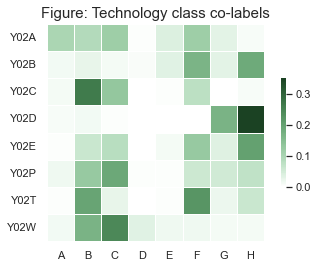

In [10]:
# Compute the correlation matrix
dice_cor = pd.DataFrame(co_occurence_dict).transpose()[cpc_labels]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(dice_cor, dtype=bool), k=0)

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=1.8, reverse=False, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatm = sns.heatmap(dice_cor,
                    #mask=mask,
                    cmap=cmap,
                    #vmax=.3,
                    vmin=0,
                    center=0,
                    square=True,
                    linewidths=.5,
                    cbar_kws={"shrink": .5})

ax.set_title("Figure: Technology class co-labels", fontdict={"fontsize":15})
ax=ax.set_yticklabels(heatm.get_yticklabels(), rotation=0)

It becomes obvious that there is substantial overlap between clean technology classes and non-clean technology classes. In other words, one and the same patent is usually assigned to more than just one technology class. More so, technology class assignment typically spans both cleantech classes (Y02) and non-cleantech classes (A-H). This makes it challenging to retrieve the information (words) that specifically describe the technology of interest.

> <span style='background :lightgreen'> **Patents are typically co-labeled with several technological classes. <br> How can we extract from a corpus of co-labeled patent texts the words that are relevant for describing the technology of interest?** </span>

### From patent texts to semantic technology descriptions 

The preprocessed patent texts can now be used to understand/model **which words are associated with high probability with a specific technology class**, $t$. In this project, this is the essential statistical learning task that needs to be solved in order to model **semantic technology descriptions**. In other words, I am interested in finding a probability vector $p(\delta_t)$ over the fixed vocabulary $V$ in the patent corpus as semantic representation of technology $t$. For this purpose, we use Labeled Latent Dirichlet Allocation (L-LDA) ([Ramage et al., 2009](https://nlp.stanford.edu/pubs/llda-emnlp09.pdf)) which is an extension of the seminal work of Blei et al. ([2003](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf?TB_iframe=true&width=370.8&height=658.8)) on unsupervised topic modeling via LDA. LDA intends to unveil a corpus' hidden topic structure (i.e. $p(\delta_t)$) by explicitly incorporating it into the generative process which led to the creation of the observed corpus of documents. Unlike LDA, which is an unsupervised machine learning model, L-LDA is supervided as it incorporates document labels (here technology classes assigned to a patent) into the modeling process.

L-LDA is implemented in the python module [tomotopy](https://bab2min.github.io/tomotopy/v0.12.2/en/). Let us load it.

In [11]:
import tomotopy as tp

In [12]:
# Instantiate L-LDA model
model = tp.PLDAModel(
            tw=tp.TermWeight.IDF, # weighting scheme
            topics_per_label=1,   # number of topics that should be modelled per label (we only want 1 topic per technology class)
            seed=333              # set seed for reproducibility
                    )  

In [18]:
# Add documents from trainings data to L-LDA model
stoplist = ['and/or', '/h', 't1', 'dc', 'mm', 'wt', '113a', '115a', 'ofdm', 'lpwa'] # define a small list of stopwords that will be excluded from modeling
for index, row in tqdm(df.iterrows()):
    clean_document = row.LEMMAS
    # Remove some additional stopwords
    clean_document = [token for token in clean_document if token not in stoplist]
    # Remove Y04 and Y10 tag
    labels = [cpc for cpc in row.CPC if cpc not in ['Y04', 'Y10']]
    # Add document and labels to model
    model.add_doc(clean_document, labels=labels)

559414it [00:51, 10885.96it/s]


In [19]:
# Train L-LDA model
model.burn_in = 5
print('Start training model:')
for i in range(0, 100, 10):
    model.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, model.ll_per_word))

# Generate a dictionary which maps L-LDAs topic index to technology class
topic2label_dict = {}
for topic, label in enumerate(model.topic_label_dict):
    topic2label_dict[label] = topic

Start training model:
Iteration: 0	Log-likelihood: -8.449261593132034
Iteration: 10	Log-likelihood: -8.433928369385006
Iteration: 20	Log-likelihood: -8.427987497694705
Iteration: 30	Log-likelihood: -8.424215985019584
Iteration: 40	Log-likelihood: -8.421561786312424
Iteration: 50	Log-likelihood: -8.419379899438294
Iteration: 60	Log-likelihood: -8.417747642426683
Iteration: 70	Log-likelihood: -8.416395830921557
Iteration: 80	Log-likelihood: -8.415326280891497
Iteration: 90	Log-likelihood: -8.414229883856887


I am interested in the word probability vector, $p(\delta_t)$, over the vocabulary for a given technology. For demonstration purposes, I'll show the word probability vector for **carbon capture and storage technologies (CCS), $t=Y02C$**.

<Figure size 720x720 with 0 Axes>

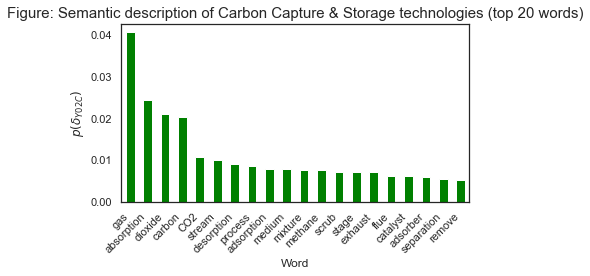

In [73]:
# Extract top words for carbon and capture technology, t=Y02C
ccs = pd.DataFrame(model.get_topic_words(topic_id=topic2label_dict['Y02C'], top_n=5000), columns=['Word', 'Prob'])

plt.figure(figsize=(10,10))
ax = ccs.head(20).plot(kind='bar', legend=False, color="green")
#ax.set_xticks(ccs.head(20).index)
ax.set_xticklabels(ccs.head(20).Word, rotation=45, ha='right')
ax.set_title("Figure: Semantic description of Carbon Capture & Storage technologies (top 20 words)", fontdict={"fontsize":15})
plt.xlabel('Word')
plt.ylabel('$p(\delta_{Y02C})$')
plt.tight_layout()

> <span style='background :lightgreen'> **Labeled Latent Dirichlet Allocation (L-LDA) allows to model a semantic technology description by "filtering" the most relevant words describing a certain technology form the corpus of patent texts.** </span>

### From semantic technology descriptions to technology embeddings

In a next step we want to transfer the semantic technology description into a numeric representation, $X_{Y02C}$, to allow downstream tasks such as proximity calculations. We do so by using pre-trained [Glove](https://aclanthology.org/D14-1162.pdf) word embeddings in order to transfer the above words in to numeric vector representations. Typically, word embeddings represent the semantic meaning of word as dense, $E$-dimensional vectors. They are obtained by effectively exploiting word co-occurence statistics from large text corpora and various neural network archtitectures exist to effectively extract these information from large text corpora.

> <span style='background :lightgreen'> **Using pre-trained word embeddings which represent the semantic meaning of a word as dense vector, we can represent a technology in vector space.** </span>

\begin{equation*}
    \underset{(Q\times E)}{X_{Y02C}} = 
        \begin{matrix}
        1 \\
        2 \\
        3 \\
        \cdots\\
        Q 
        \end{matrix}
        \begin{matrix}
        gas \rightarrow\\
        absorption \rightarrow\\
        dioxide \rightarrow\\
        \cdots\\
        solution \rightarrow
        \end{matrix}
        \begin{bmatrix}
                0.479 & -0.016 & 1.419 & \cdots        & 0.669  & -0.187 & -0.763\\
                0.315 & 0.749  & 0.446 & \cdots        & -0.062 & -0.163 & 0.166 \\
                0.177 & 0.874  & 1.291 & \cdots                     & -0.359 & 0.361  & -0.311\\
                \vdots&        &       &                            &        &        & \vdots\\
                0.566 & 0.079  & -0.713& \cdots  & 0.646  & -0.177 & 0.308
        \end{bmatrix}
\end{equation*}
    

In [22]:
# Read pre-trained word embeddings
embeddings_index = {}
with open(config.PATH_TO_GLOVE + '/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [74]:
# Create DataFrame with the word embeddings of the Q words that describe carbon capture and storage technologies with highest probability
techword_embeddings = []
for ind, row in ccs.iterrows():
    techword_embeddings.append((row.Word, row.Prob, embeddings_index.get(row.Word, None)))
df_embeddings = pd.DataFrame(techword_embeddings, columns=['Word', 'Prob', 'Embedding'])

In [26]:
# Take a look at the embeddings
df_embeddings.head(3)

,Word,Prob,Embedding
0,gas,0.040544,"[0.47911, -0.016612, 1.419, 0.48327, -0.34749,..."
1,absorption,0.024292,"[0.31457, 0.74851, 0.44596, -0.91002, -0.11374..."
2,dioxide,0.020952,"[0.22507, 0.39496, 1.4269, -0.88639, -0.67507,..."


In [ ]:
n_words = [10, 20, 30, 40, 50, 100, 250, 500, 1000, 2000, 3000, 4000]
semantic_vectors_wavg = {}
for n_word in n_words:
    df_temp = df_embeddings.dropna()
    embeddings = df_temp.head(n_word).Embedding.values
    weights = df_temp.head(n_word).Prob.values
    embedding = np.average(embeddings, axis=0, weights=weights)
    semantic_vectors_wavg[n_word] = embedding

## Scraping a web data source 

> <span style='background :lightgreen'> **Now that we have modeled technology embeddings, we want to analyze how "close" companies are located to these technologies in vector space. For this purpose, we scrape company information listed in the [2021 Global Cleantech 100 List](https://i3connect.com/gct100/the-list).** </span>

The Global Cleantech 100 comprise companies that were selected by a panel of 91 industry experts comprised of investor and multi-national corporation representatives all active in cleantech sectors. The panel votes positively or negatively whether a company is suitable for the Global Cleantech 100 list based on their knowledge of the company’s innovation, market and ability to execute. Finally, adjustments correcting for geographic or other biases are made to come up with the final list.

In [1]:
# Setup
options(warn=-1)
options(readr.num_columns = 0)
library("here")
source(here("02_Code//util.R"))

here() starts at Q:/Meine Bibliotheken/Research/01_Promotion/05_Ideas/09_Cleantech/cleantech

Lade nötiges Paket: pacman



In [2]:
# Scrape information found in table
url <- "https://i3connect.com/gct100/the-list"
base_table <- scrape_tab(url)

# Scrape information found on firm-specific site
df_cleantech <- lapply(base_table$HREF, function(url) cached_scrape_firminfo(url, pattern_vector)) %>% bind_rows()

# Clean data
df_cleantech <- df_cleantech %>% 
  na_if('null') %>% 
  na_if("") %>% 
  na_if("N/A") %>% 
  mutate(primary_tag = str_replace(primary_tag, pattern = "\\\\u0026", replacement = "&"),
         industry_group = str_replace(industry_group, pattern = "\\\\u0026", replacement = "&")) %>% 
  clean_names("all_caps") %>% 
  type_convert()

In [3]:
df_cleantech %>% head(3) %>% select(NAME, ADDRESS, CITY, STATE, ZIP, SHORT_DESCRIPTION, WEBSITE)

NAME,ADDRESS,CITY,STATE,ZIP,SHORT_DESCRIPTION,WEBSITE
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
75F,221 River Ridge Circle South,Bloomington,MN,55337,"Developer of a predictive building automation system that addresses HVAC, lighting, and equipment control requirements",http://www.75f.io
AgriProtein,NA,Guilford,NA,NA,Upcycler of organic waste using insects and technology to produce sustainable protein for animal and aquaculture feed,http://www.agriprotein.com/
Akselos,"EPFL, Innovation Park, Building D",Lausanne,NA,1015,Provider of predictive physics-based digital twins for the management of large energy assets,https://akselos.com/


## Mapping the data 

We now have detailed information on the "Top 100 Cleantech Companies". Let us put them on the map using the company addresses.

In [60]:
# Read test data of cleantech firms
df_cleantech = pd.read_csv(here('01_Data/02_Firms/df_cleantech_firms.txt'), sep='\t', encoding='utf-8')
df_cleantech[['NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP']].head(5)

,NAME,ADDRESS,CITY,STATE,ZIP
0,75F,221 River Ridge Circle South,Bloomington,MN,55337
1,AgriProtein,NaN,Guilford,NaN,NaN
2,Akselos,"EPFL, Innovation Park, Building D",Lausanne,NaN,1015
3,Alpha ESS,"Jiu Hua Road 888, Nantong High-Tech Industrial...",Nantong City,NaN,226300
4,AMP Robotics,1500 Cherry St Suite A,Louisville,CO,80027


In [30]:
# Is the city name missing for any of the cleantech companies?
df_cleantech[['CITY']].isnull().sum()

CITY    0
dtype: int64

Get the geocodes for the companies' city names using the geocoder module.

In [31]:
import geocoder

In [32]:
df_cleantech['LONLAT'] = df_cleantech.CITY.apply(lambda x: geocoder.arcgis(x).latlng)

In [35]:
# Did we retrieve geocodes for all firms?
df_cleantech.LONLAT.isnull().sum()

0

In [33]:
# Create seperate columns for longitude and latitude
df_cleantech['LAT'] = df_cleantech.LONLAT.apply(lambda x: x[0])
df_cleantech['LON'] = df_cleantech.LONLAT.apply(lambda x: x[1])

In [34]:
import geopandas as gpd
world_map = gpd.read_file(here('01_Data/03_Geo/world_map.json'))

In [35]:
df_cleantech_geo = gpd.GeoDataFrame(df_cleantech, geometry=gpd.points_from_xy(df_cleantech["LON"], df_cleantech["LAT"]))

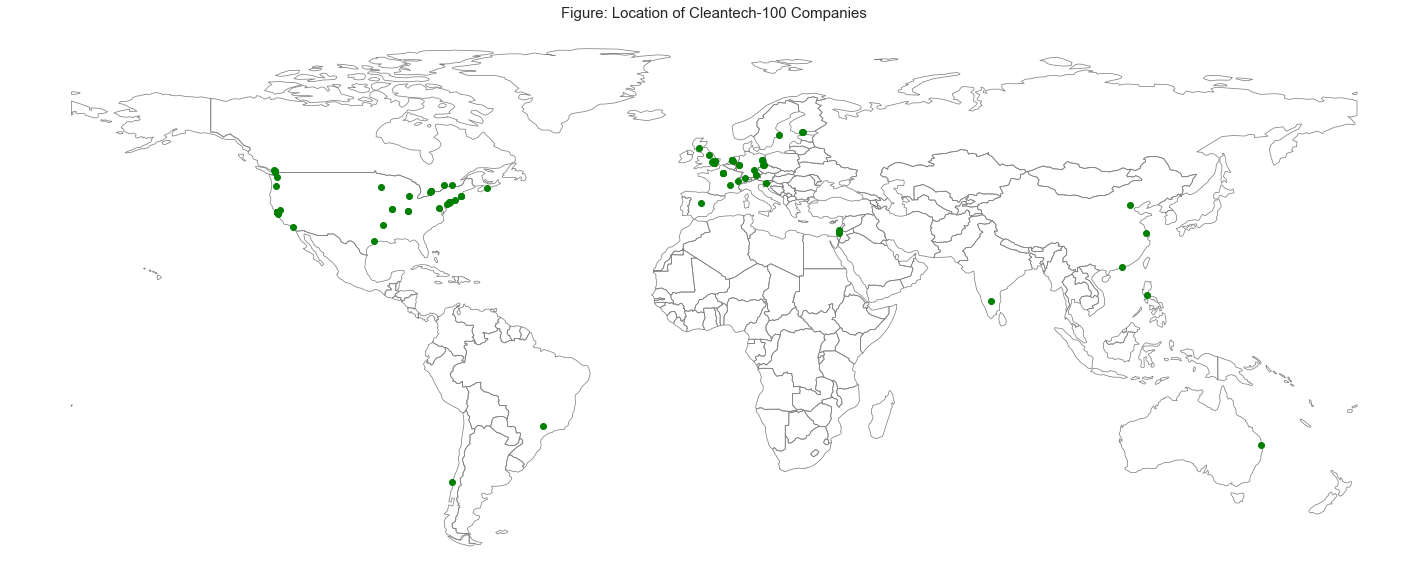

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

world_map.boundary.plot(ax=ax, zorder=1, color="grey", linewidth=0.75) # using .boundary tells geopandas to only plot the boundary of polygons
points = df_cleantech_geo.plot(ax=ax, zorder=2, scheme="NaturalBreaks", color="green")
ax.set_axis_off()
ax.set_title("Figure: Location of Cleantech-100 Companies", fontdict={"fontsize":15})
fig.tight_layout() 

## Technological proximity and executive summary 

Ultimately, we can use the technological vector spaces and the company descriptions to analyze how "closely" the respective company is located to the technology. For this purpose, we use all the textual information of the company that is available to us.

In [61]:
from util import create_joint_string

In [64]:
df_cleantech['DESCRIPTION'] = df_cleantech.apply(lambda x: create_joint_string(x), axis=1)
df_cleantech = df_cleantech[['NAME', 'DESCRIPTION']].copy()

First, we lemmatize the company descriptions in the same way as we did for the patent texts.

In [65]:
df_cleantech['LEMMAS'] = df_cleantech.DESCRIPTION.apply(lambda x: string_to_lemma(x))

In [66]:
df_cleantech.head(3)

,NAME,DESCRIPTION,LEMMAS
0,75F,Developer of a predictive building automation ...,"[developer, predictive, building, automation, ..."
1,AgriProtein,Upcycler of organic waste using insects and te...,"[upcycler, organic, waste, insect, technology,..."
2,Akselos,Provider of predictive physics-based digital t...,"[provider, predictive, physics-based, digital,..."


In [258]:
from sklearn.metrics.pairwise import cosine_similarity
from util import cosine_similarity_vectors
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
model._first_module().max_seq_length = 510 # increase maximum sequence length which is 128 by default

In [240]:
def company_to_embedding(company_description, embedding_type="static"):
    if embedding_type=='static':    
        # Extract word embedding if exist, else return None
        embedding_list = [list(embeddings_index.get(word, [])) for word in company_description]
        # Drop None from resulting list
        embedding_list = list(filter(None, embedding_list))
        # Create numpy array
        embedding = np.array(embedding_list)
    if embedding_type=='contextualized':
        # Concatenate list of words to whitespace seperated string
        word_concatenation = ' '.join(str(i) for i in company_description)
        # Create numpy array of sentence embedding
        embedding = model.encode(word_concatenation)      
    return(embedding)

In [252]:
def technological_proximity(company_description, Q, embedding_type='static'):
    technology_embedding = technology_to_embedding(Q, embedding_type=embedding_type)
    company_embedding = company_to_embedding(company_description, embedding_type=embedding_type)
    if  embedding_type=='static':
        techprox = cosine_similarity(company_embedding, technology_embedding).flatten().mean()
    if  embedding_type=='contextualized':
        techprox = cosine_similarity_vectors(company_embedding, technology_embedding).flatten().mean()
    return(techprox)

In [266]:
temp = []
    
for index, row in tqdm(df_cleantech.iterrows(), total=df_cleantech.shape[0], position=0, leave=True):
    # Define textual input for proximity to technology space shall be calculated
    company_description = row.LEMMAS
    ind = row.NAME
    text = row.DESCRIPTION

    # Create word embedding matrix
    company_embedding = company_to_embedding(company_description)
    len_embedding = len(company_embedding)
    # Only if company descriptions/lemmas thereof exist, continue with the proximity calculation
    if len_embedding != 0:

        # Calculate proximity to all clean technology semantic spaces
        for Q in [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]:
            #technology_embedding = technology_to_embeddging(Q)

            # Calculate cosine similarity between all permutations of patent vector space and technology semantic vector space
            tech_proximity = technological_proximity(company_description, Q)
            temp.append([ind, text, company_description, Q, tech_proximity])
            
    else:
        continue
        
df_proximity = pd.DataFrame(temp, columns=['NAME', 'DESCRIPTION', 'LEMMAS', 'N_TOP_WORDS', 'PROXIMITY'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.68it/s]


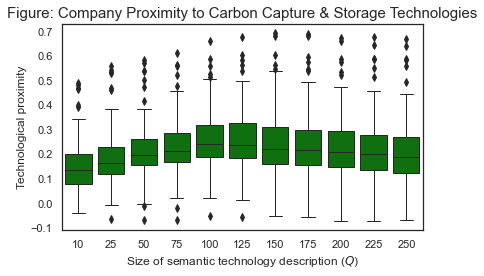

In [270]:
fig, ax = plt.subplots(1,1)

ax = sns.boxplot(x="N_TOP_WORDS", y="PROXIMITY", data=df_proximity, linewidth=1, ax=ax, color="green")
ax.set_title('Figure: Company Proximity to Carbon Capture & Storage Technologies', fontdict={"fontsize":15})
ax.set_xlabel('Size of semantic technology description ($Q$)')
ax.set_ylabel('Technological proximity')

fig.tight_layout()

In [271]:
df_proximity.loc[df_proximity.N_TOP_WORDS==50].sort_values('PROXIMITY', ascending=False).head(5)[['NAME', 'DESCRIPTION']].style.set_properties(subset=['DESCRIPTION'], **{'width': '1200px'})

,NAME,DESCRIPTION
178,Carbon Engineering,"Developer of technologies for the capture of carbon dioxide from the atmosphere at industrial scale Carbon Engineering’s patented technology integrates two processes: an air contactor, and a regeneration cycle, for continuous capture of atmospheric carbon dioxide and production of pure CO2.\r\nThese two processes work together to enable continuous capture of CO2 from atmospheric air, with energy (and small amounts of make-up chemicals) as an input, and pure CO2 as an output. The stream of pure CO2 can be sold and used in industrial applications and/or permanently sequestered (geologically stored) deep underground.\r\nThe capture system brings atmospheric air containing CO2 into contact with a chemical solution that naturally absorbs CO2, in a device called a contactor. This solution, now containing the captured CO2, is sent to a regeneration cycle that simultaneously extracts the CO2 as a high-pressure pipeline-quality product while regenerating the original chemical solution, for re-use in the contactor. Carbon Engineering has developped an air capture of CO2 system that would enable large facilities to manage emissions from any source or location so that industrial economies of scale can be applied to the large fraction of emissions that come from distributed and mobile sources such as vehicles, airplanes, and buildings."
156,C-Capture,"Developer of solvents for use in carbon capture and storage (CCS) applications Existing technologies for post-combustion capture focus on the use of aqueous amine-based processes, whereas C-Capture’s absorbents are amine-free. The new solvents developed by C-Capture offer potential opportunities for improvements for CCS implementation including: energy and cost savings, utilisation of renewable rather than petrochemically derived materials, low volatility and low toxicity, biodegradability and biocompatibility and readily availabile and inexpensive in nature.\r\n\r\nC-Capture has demonstrated the potential of their absorbents in the laboratory and are now being studied for implementation in systems representative of commercial scale capture processes. C-Capture is developing solvents for carbon capture and storage (CCS) implementation."
167,Carbon Clean,"Developer of CO2 capture technology that significantly reduces the costs and environmental impacts of CO2 separation Carbon Clean has developed breakthrough solvents that can reduce the cost of CO2 capture from large scale polluters like industrial plants by 50%. Once captured, CO2 is reused. CCS’ patented technology can also be used in existing gas treatment plants in natural gas industry to reduce operating costs by 30%. Company's is selling it's products commercially and has just closed $8m financing round."
189,CarbonCure Technologies,"Developer of a permanent carbon removal technology for concrete production CarbonCure’s Block System takes carbon dioxide from large emitters and sequesters it into solid limestone within the final concrete product. The process uses less concrete and energy and produces less waste compared to conventional concrete manufacturing techniques. According to the Company, Installation of the Block System does not require other equipment or changes in operating procedure. CarbonCure's CO2 utilization technology allows concrete production to gain a competitive sales by lowering production costs and improving CO2, water and solid waste performance. Its technology is installed across nearly 150 major concrete producers across North America and Asia."
233,Climeworks,"Developer of direct air capture technology that safely and permanently removes carbon dioxide from the air Climeworks empowers people to reverse climate change by permanently removing carbon dioxide from the air with its direct air capture technology.\nThe air-captured CO2 can either be stored safely and permanently, or upcycled into renewable fuels and materials. Climeworks is the market leader for direct air capt

In [268]:
temp = []
    
for index, row in tqdm(df_cleantech.iterrows(), total=df_cleantech.shape[0], position=0, leave=True):
    # Define textual input for proximity to technology space shall be calculated
    company_description = row.LEMMAS
    ind = row.NAME
    text = row.DESCRIPTION

    # Create word embedding matrix
    company_embedding = company_to_embedding(company_description, embedding_type='contextualized')
    len_embedding = len(company_embedding)
    # Only if company descriptions/lemmas thereof exist, continue with the proximity calculation
    if len_embedding != 0:

        # Calculate proximity to all clean technology semantic spaces
        for Q in [10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]:
            #technology_embedding = technology_to_embeddging(Q)

            # Calculate cosine similarity between all permutations of patent vector space and technology semantic vector space
            tech_proximity = technological_proximity(company_description, Q, embedding_type='contextualized')
            temp.append([ind, text, company_description, Q, tech_proximity])
            
    else:
        continue
        
df_proximity = pd.DataFrame(temp, columns=['NAME', 'DESCRIPTION', 'LEMMAS', 'N_TOP_WORDS', 'PROXIMITY'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


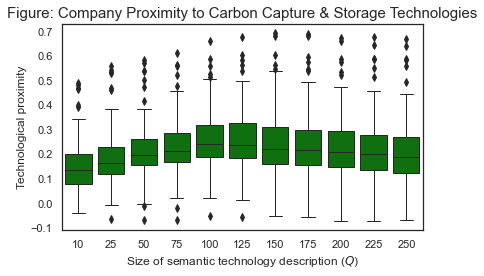

In [269]:
fig, ax = plt.subplots(1,1)

ax = sns.boxplot(x="N_TOP_WORDS", y="PROXIMITY", data=df_proximity, linewidth=1, ax=ax, color="green")
ax.set_title('Figure: Company Proximity to Carbon Capture & Storage Technologies', fontdict={"fontsize":15})
ax.set_xlabel('Size of semantic technology description ($Q$)')
ax.set_ylabel('Technological proximity')

fig.tight_layout()

Let us take a look at the companies which have the highest proximity to Carbon Capture & Storage Technologies in vector space:

In [264]:
df_proximity.loc[df_proximity.N_TOP_WORDS==100].sort_values('PROXIMITY', ascending=False).head(5)[['NAME', 'DESCRIPTION']].style.set_properties(subset=['DESCRIPTION'], **{'width': '1200px'})

,NAME,DESCRIPTION
180,Carbon Engineering,"Developer of technologies for the capture of carbon dioxide from the atmosphere at industrial scale Carbon Engineering’s patented technology integrates two processes: an air contactor, and a regeneration cycle, for continuous capture of atmospheric carbon dioxide and production of pure CO2.\r\nThese two processes work together to enable continuous capture of CO2 from atmospheric air, with energy (and small amounts of make-up chemicals) as an input, and pure CO2 as an output. The stream of pure CO2 can be sold and used in industrial applications and/or permanently sequestered (geologically stored) deep underground.\r\nThe capture system brings atmospheric air containing CO2 into contact with a chemical solution that naturally absorbs CO2, in a device called a contactor. This solution, now containing the captured CO2, is sent to a regeneration cycle that simultaneously extracts the CO2 as a high-pressure pipeline-quality product while regenerating the original chemical solution, for re-use in the contactor. Carbon Engineering has developped an air capture of CO2 system that would enable large facilities to manage emissions from any source or location so that industrial economies of scale can be applied to the large fraction of emissions that come from distributed and mobile sources such as vehicles, airplanes, and buildings."
158,C-Capture,"Developer of solvents for use in carbon capture and storage (CCS) applications Existing technologies for post-combustion capture focus on the use of aqueous amine-based processes, whereas C-Capture’s absorbents are amine-free. The new solvents developed by C-Capture offer potential opportunities for improvements for CCS implementation including: energy and cost savings, utilisation of renewable rather than petrochemically derived materials, low volatility and low toxicity, biodegradability and biocompatibility and readily availabile and inexpensive in nature.\r\n\r\nC-Capture has demonstrated the potential of their absorbents in the laboratory and are now being studied for implementation in systems representative of commercial scale capture processes. C-Capture is developing solvents for carbon capture and storage (CCS) implementation."
191,CarbonCure Technologies,"Developer of a permanent carbon removal technology for concrete production CarbonCure’s Block System takes carbon dioxide from large emitters and sequesters it into solid limestone within the final concrete product. The process uses less concrete and energy and produces less waste compared to conventional concrete manufacturing techniques. According to the Company, Installation of the Block System does not require other equipment or changes in operating procedure. CarbonCure's CO2 utilization technology allows concrete production to gain a competitive sales by lowering production costs and improving CO2, water and solid waste performance. Its technology is installed across nearly 150 major concrete producers across North America and Asia."
796,Sierra Energy,"Developer of FastOx waste gasification technology FastOx leverages the centuries-old blast furnace, as an efficient and scalable means to convert nearly any form of waste into renewable energy. Sierra Energy elevates the blast furnace into a waste gasifier by replacing the hot blast of air with injections of steam and oxygen, thus operating more efficiently and increasing the value of the syngas produced. It is this innovation that allows FastOx gasifiers to produce syngas clean enough to be used in renewable fuel production. \n\nThe FastOx Pathfinder converts waste into high-value, ultra-clean fuels or electricity. This turn-key system is designed to handle up to 25 tons of feedstock intake each day. The modular system contains shipping containers, each weighing less than 5 tons, allowing the entire system able to be hauled by truck or rail. Its 7 containers consist of: a FastOx gasifier, an air separation unit, a shredder for feedstoc

> <span style='background :lightgreen'> **Companies whose business models rely on Carbon Capture & Storage Technologies show the highest proximity to the CCS technology embedding.** </span>

This project has shown that:
- we can model semantic technology descriptions from a labeled corpus of patent texts using L-LDA 
- there is great flexibility w.r.t. which technology is modeled (technology classes allow a great degree of differentiation both horizontally and vertically)
- using word embeddings we can leverage a semantic technology descriptions into vector space (technology embeddings) allowing downstream tasks such as measuring text similarity
- having textual information of companies at hand, we can measure technological proximity of a firm to a technology by using the same embedding method as for the technologies
- this methods shows promising results as displayed in this notebook for the case of Carbon Capture & Storage Technologies